In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [34]:
## Same plot but bootstrapped. Also, allow smaller s.

n = 2
Q = 10

df = pd.read_csv('./../../data/processed/ID_Y.csv')


In [3]:

for i in [0, 1]:
    sales = df.loc[df.IMPORT == i].groupby(['ID', 'YEAR'])['VART'].sum().unstack()
    sales = sales.loc[sales.sum(1).sort_values().index]

    base_out_list = []
    total_out_list = []

    for m in range(n):
        if m%10 == 0: print(m)

        df_bs_ = sales.sample(frac = .5)

        for size_sorting in [False, True]:
            logsales = np.log10(sales)
            micro_s = logsales.sub(logsales.mean(1), axis=0).unstack().std()
            s = np.round(micro_s, 2)
            
            if size_sorting: 
                df_bs = df_bs_.loc[df_bs_.sum(1).sort_values().index] #sorting
            else:
                df_bs = df_bs_

            total = df_bs.copy()
            
#             logsales = np.log10(df_bs)
            total['q'] = pd.cut(total.sum(1).cumsum(), Q, labels = range(Q))
            nqs = total['q'].value_counts().values
            
            total_yqs = total.groupby(total['q']).sum()        
            total_yqs['m'] = m; total_yqs['nqs'] = nqs; total_yqs['s'] = s; total_yqs['parts'] = ['P', 'Q'][size_sorting];

            total_yqs = total_yqs.reset_index().set_index(['parts','q', 'm', 's', 'nqs'])

0
0


In [4]:
total_yqs.sum()

YEAR
1997    1.218077e+11
1998    1.308212e+11
1999    1.339877e+11
2000    1.583849e+11
2001    1.568490e+11
2002    1.524541e+11
2003    1.478163e+11
2004    1.648310e+11
2005    1.895477e+11
2006    2.083864e+11
2007    2.195503e+11
2008    2.293578e+11
2009    1.876417e+11
2010    2.161529e+11
2011    2.386730e+11
2012    2.459288e+11
2013    2.602359e+11
dtype: float64

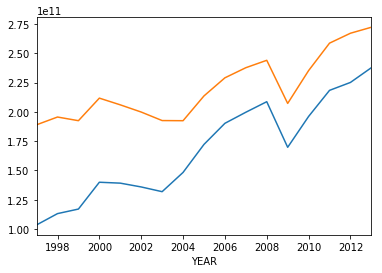

In [5]:
## Drop first quantile:
## Large firms Pareto
lfp = total.loc[total.q > 0]

# Large firms pareto filled median. 
lfp_fm = lfp.copy()
for col in lfp_fm.columns[:-1]:
    lfp_fm[col] = lfp_fm[col].fillna(lfp.mean(axis=1))
## Its a mock dataset with no entry and exit.

lfp.sum()[:-1].plot() ## Pareto dataset
lfp_fm.sum()[:-1].plot()  ## Na inflated Pareto dataset.
plt.show()

In [6]:
from IPython.display import display, Math, Latex

### Eq. 1:
$\frac{\Delta S_{i, t+1}}{S_{it}} = \frac{S_{i, t+1} - S_{it}}{S_{it}} = \sigma_i \epsilon_{i, t+1}$

In [7]:
firm_ts = lfp_fm.drop('q', axis = 1)

# These are the same
pct_change = 100*firm_ts.pct_change(axis = 1).head()
pct_change = 100*firm_ts.fillna(0).diff(axis = 1).div(firm_ts.shift(1, axis = 1))

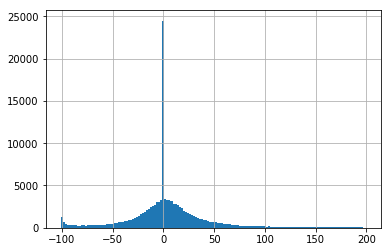

In [8]:
# Distribution of percent rates.

pct_change.stack().hist(bins = range(-101, 200, 2))
plt.show()

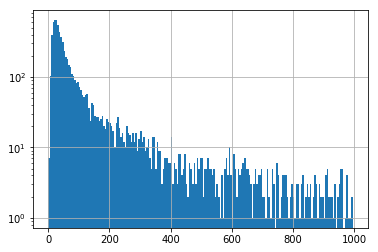

In [9]:
## Can one say that the sigmas are a unique value?
pct_change.std(1).hist(bins = np.arange(0, 1000, 5))
plt.yscale('log')
plt.show()

## Equation 

Growth of: $Y_{t} = \sum_i S_{it}$

$\frac{\Delta Y_{t+1}}{Y_t} = \frac{1}{Y_t} \sum_i \Delta S_{i, t+1} = \sum_i \sigma_i \frac{S_{it}}{Y_t} \epsilon_{i, t+1}$

Valid if the numerators are equal for all i

In [10]:
p1 = firm_ts.sum().diff() # DY

p2 = firm_ts.fillna(0).diff(axis = 1).sum() # Sum of DS

## How to define it for the last eq? Given that there are lot of entry/exits and non defined sigma i's.

## Distribution of sigmas and epsilon given by:

$\sigma_i \epsilon_{i, t+1} = \Delta S_{i, t+1}/S_{it}$

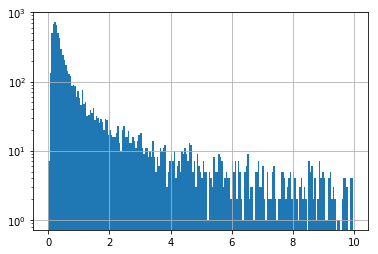

In [11]:
s_eps = firm_ts.diff(axis = 1).div(firm_ts)
eps = s_eps.div(s_eps.std(1), axis = 0)
eps.round(2)

s_eps.std(1).hist(bins = np.arange(0, 10, .05))
plt.yscale('log')
plt.show()

std(\epsilon): 1.0066031666865491


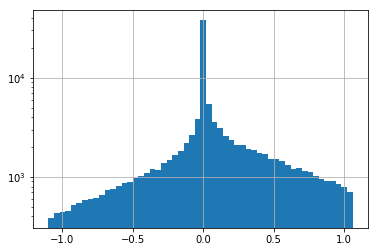

In [12]:
## The std is near 1. That is Ok but what is its distribution? It is not Gaussian.
print('std(\epsilon): '+str(eps.stack().std()))

eps.stack().hist(bins = np.arange(-1.1, 1.1, .04))
plt.yscale('log')
plt.show()

## Herfindahl

as $\sqrt{\sum_i Si^2}/ (N E[Si])$

(Eqs 11 and 12)

In [13]:
Si = firm_ts.sum(1)
h = np.sqrt((Si**2).sum())/(Si).sum()
print(h)

# #  We can replace:
N = len(firm_ts)
Si.sum()/N
Si.mean()

h = np.sqrt((Si**2).sum())/ (N * Si.mean())
print(h)

0.07819231727089812
0.07819231727089812


## Eq 4:

$\sigma_{GDP} = \sigma h$

0.05332493078768958
0.6819714858039669


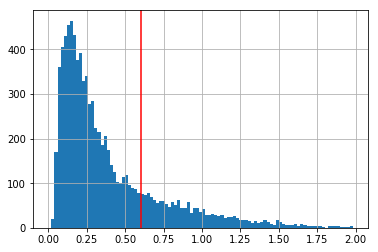

In [14]:
s_gdp = np.log10(firm_ts.sum()).std()
s_eff = s_gdp/h

print(s_gdp)
print(s_eff)

# print(np.log10(s_eff))

fig, ax = plt.subplots(1)
np.log10(firm_ts).std(1).hist(bins = np.arange(0, 2, .02), ax = ax)
ax.axvline(.6, c = 'r')
plt.show()

### What does Pareto look like? Eq 13:
$S_{i, N} = (i / N)^{-1/\zeta}$

I added the constant a = 10^8. The a is missing

0
 
-1.201 x + 11.84
 
-1.192 x + 11.8
 
-1.175 x + 11.66
 
-1.218 x + 11.96
 
-1.21 x + 11.89


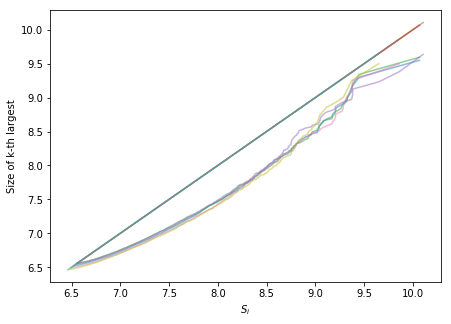

0
 
-1.104 x + 11.16
 
-1.153 x + 11.47
 
-1.139 x + 11.4
 
-1.256 x + 12.24
 
-1.231 x + 12.05


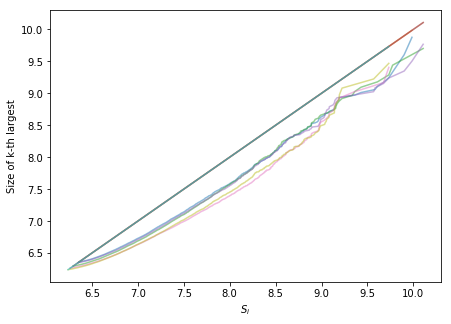

In [15]:
n = 5

for i in [0, 1]:
    sales = df.loc[df.IMPORT == i].groupby(['ID', 'YEAR'])['VART'].sum().unstack()
    sales = sales.loc[sales.sum(1).sort_values().index]

    base_out_list = []
    total_out_list = []

    fig, ax = plt.subplots(1, figsize = (7, 5))
    
    for m in range(n):
        if m%10 == 0: print(m)

        df_bs_ = sales.sample(frac = .5)
        
        size_sorting = True

        logsales = np.log10(sales)
        micro_s = logsales.sub(logsales.mean(1), axis=0).unstack().std()
        s = np.round(micro_s, 2)

        if size_sorting: 
            df_bs = df_bs_.loc[df_bs_.sum(1).sort_values().index] #sorting
        else:
            df_bs = df_bs_

        total = df_bs.copy()
        total['q'] = pd.cut(total.sum(1).cumsum(), Q, labels = range(Q))
        
        ## Drop first quantile:
        ## Large firms Pareto
        lfp = total.loc[total.q > 0]

        # Large firms pareto filled median. 
        lfp_fm = lfp.copy()
        for col in lfp_fm.columns[:-1]:
            lfp_fm[col] = lfp_fm[col].fillna(lfp.mean(axis=1))
        ## Its a mock dataset with no entry and exit.
        firm_ts = lfp_fm.drop('q', axis = 1)
        
        if size_sorting: 
            firm_ts = firm_ts.loc[firm_ts.sum(1).sort_values().index] #sorting
        else:
            pass

        N = len(firm_ts)

        #### FIT PARETO
        
        log_vals = np.log10(firm_ts.mean(1))

        bins = pd.DataFrame(pd.cut(log_vals, np.arange(log_vals.min(), log_vals.max(), .1)).dropna().value_counts(), columns=['n'])
        bins['mid'] = np.array([(b.mid).round(6) for b in bins.index.values])
        bins['CCDF'] = bins['n'].sum() - bins['n'].cumsum()
        bins['lCCDF'] = np.log10(bins['CCDF'] + 1)

        # bins.plot('mid', 'lCCDF', marker = '.', lw = 0)
        x = bins.mid.values; y = bins.lCCDF.values
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        print(p)

        ### After having fit Pareto, change firm level means to exact pareto expectation.

        S = firm_ts.mean(1).sort_values(ascending = False).reset_index(drop = True)
        i = S.index + 1
        z = -p[1]
        xm = S.min()
        
#         #####
# #         ## Comment if not desired
#         firm_ts = firm_ts.subtract(firm_ts.mean(1), axis = 0).add((xm*(i/N)**(-1/z)).values[::-1], axis = 0)
#         # Repeat:
#         S = firm_ts.mean(1).sort_values(ascending = False).reset_index(drop = True)
#         i = S.index + 1
#         z = -p[1]
#         xm = S.min()

#         ######
        
        x = np.log10(S)
        y = np.log10(xm) - np.log10(i/N)/z #+.25

        ax.plot(x, y, alpha = .5)
        ax.plot(x, x, alpha = .5) # 
        ax.set_xlabel(r'$S_i$'); ax.set_ylabel('Size of k-th largest')
    plt.show()


In [16]:
## The validity of eq. 13, from where dependence of h with N is derived.

h1 = np.sqrt(sum((S/S.sum())**2))
h2 = np.sqrt(sum(S**2))/(N*S.mean())

# Eq 13 is valid if the following are equal to the previous
h3 = np.sqrt(sum(xm**2 * (i/N)**(-2/z)))/(N*S.mean())
h4 = np.sqrt(sum(i**(-2/z)))*N**(-1 + 1/z)*(xm/S.mean())

print(h1, h2, h3, h4)

0.04927985995617594 0.04927985995617605 0.022040621904599985 0.022040621904600006


In [17]:
## We could "save it" if we use the Herfindahl wihtout making it depend on N by eq 13.

## Then we would come back to sigma_tot = h . sigma_eff, which may be not valid as well.

## Instead I would need to express sigma_tot(N) with my approach (idyosynchratic sigma) and try to let it match the observed values.

In [18]:
# ### It may be possible that z changes with sample size...

# for s in [.6, .75, .9]:
#     print(s)
#     result = []
#     for r in range(15):
#         data = firm_ts.sample(frac = s)
#         log_vals = np.log10(data.mean(1))

#         bins = pd.DataFrame(pd.cut(log_vals, np.arange(log_vals.min(), log_vals.max(), .1)).dropna().value_counts(), columns=['n'])
#         bins['mid'] = np.array([(b.mid).round(6) for b in bins.index.values])
#         bins['CCDF'] = bins['n'].sum() - bins['n'].cumsum()
#         bins['lCCDF'] = np.log10(bins['CCDF'] + 1) ## Seems to be sensible to the location of the largest point

#         # bins.plot('mid', 'lCCDF', marker = '.', lw = 0)
#         x = bins.mid.values; y = bins.lCCDF.values
#         z = np.polyfit(x, y, 1)
#         p = np.poly1d(z)
# #         print(p)
#         result += [p[1]]
#     result = np.array(result)
#     print(np.percentile(result, .25))
#     print(np.percentile(result, .75))

## Dependence of Herfindahl with sample size N

In [67]:
M = 35

for i in [1]:
    sales = df.loc[df.IMPORT == i].groupby(['ID', 'YEAR'])['VART'].sum().unstack()
    sales = sales.loc[sales.sum(1).sort_values().index]

    base_out_list = []
    total_out_list = []
   
    logn_vals = np.arange(3, np.log10(len(sales)), .35)
    n_vals = np.round(10**logn_vals, -2)

    outa1 = np.zeros((len(n_vals), M))
    outa2 = np.zeros((len(n_vals), M))
    outb1 = np.zeros((len(n_vals), M))
    outb2 = np.zeros((len(n_vals), M))
            
    for j, n in enumerate(n_vals):

        for m in range(M):
            
            if m%10 == 0: print(m)

            df_bs_ = sales.sample(int(n))

            size_sorting = True

            logsales = np.log10(sales)
            micro_s = logsales.sub(logsales.mean(1), axis=0).unstack().std()
            s = np.round(micro_s, 2)

            if size_sorting: 
                df_bs = df_bs_.loc[df_bs_.sum(1).sort_values().index] #sorting
            else:
                df_bs = df_bs_

            total = df_bs.copy()
            total['q'] = pd.cut(total.sum(1).cumsum(), Q, labels = range(Q))

            ## Drop first quantile:
            ## Large firms Pareto
            lfp = total.loc[total.q > 0]

            # Large firms pareto filled median. 
            lfp_fm = lfp.copy()
            for col in lfp_fm.columns[:-1]:
                lfp_fm[col] = lfp_fm[col].fillna(lfp.mean(axis=1))
            ## Its a mock dataset with no entry and exit.
            firm_ts = lfp_fm.drop('q', axis = 1)

            if size_sorting: 
                firm_ts = firm_ts.loc[firm_ts.sum(1).sort_values().index] #sorting
            else:
                pass

            N = len(firm_ts)

            #### FIT PARETO

            log_vals = np.log10(firm_ts.mean(1))

            bins = pd.DataFrame(pd.cut(log_vals, np.arange(log_vals.min(), log_vals.max(), .1)).dropna().value_counts(), columns=['n'])
            bins['mid'] = np.array([(b.mid).round(6) for b in bins.index.values])
            bins['CCDF'] = bins['n'].sum() - bins['n'].cumsum()
            bins['lCCDF'] = np.log10(bins['CCDF'] + 1)

            # bins.plot('mid', 'lCCDF', marker = '.', lw = 0)
            x = bins.mid.values; y = bins.lCCDF.values
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
#             print(p)


            S = firm_ts.mean(1).sort_values(ascending = False).reset_index(drop = True)
            i = S.index + 1
            z = -p[1]
            xm = S.min()

            try:
                ha1 = np.sqrt(sum((S/S.sum())**2)) 
                ha2 = np.sqrt(sum(i**(-2/z)))*N**(-1 + 1/z)*(xm/S.mean())  ## This one differs
            except:
                pass
            
            #####
            ## After having fit Pareto, change firm level means to exact pareto expectation.
    #         ## Comment if not desired
            firm_ts = firm_ts.subtract(firm_ts.mean(1), axis = 0).add((xm*(i/N)**(-1/z)).values[::-1], axis = 0)
            # Repeat:
            S = firm_ts.mean(1).sort_values(ascending = False).reset_index(drop = True)
            i = S.index + 1
            z = -p[1]
            xm = S.min()

            ######

            try:
                hb1 = np.sqrt(sum((S/S.sum())**2)) # 
                hb2 = np.sqrt(sum(i**(-2/z)))*N**(-1 + 1/z)*(xm/S.mean()) ## These two go together, they coincide.
            except:
                pass
            
            outa1[j, m] = ha1
            outa2[j, m] = ha2
            outb1[j, m] = hb1
            outb2[j, m] = hb2
            
            
    #         x = np.log10(S)
    #         y = np.log10(xm) - np.log10(i/N)/z #+.25



0
10
20
30
0
10
20
30
0
10
20
30
0
10
20
30
0
10
20
30
0
10
20
30
0
10
20
30
0
10
20
30


In [66]:
z
# np.sqrt(sum(i**(-2/z)))*N**(-1 + 1/z)*(xm/S.mean())

0

 
-0.2564 x + 0.3242
 
-0.4158 x + 0.6999
 
-0.2949 x + 0.4662
 
-0.2949 x + 0.4662


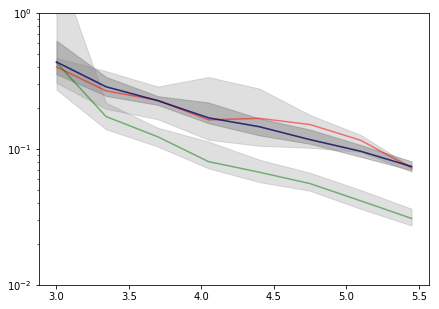

In [68]:
# -1 + 1/1.15

fig, ax = plt.subplots(1, figsize = (7, 5))

for i, df_ in enumerate([outa1, outa2, outb1, outb2]):
    res = pd.DataFrame(df_, index=list(n_vals))
    res = res.T.describe().T

    ax.fill_between(np.log10(res.index), res['25%'].values, res['75%'].values, color = '.5', alpha = .25)
    ax.plot(np.log10(res.index), res['50%'].values, color = ['r', 'g', 'b', 'k'][i], alpha = .5)
    
    x = np.log10(res.index)
    y = np.log10(res['50%'].values)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z); print(p)

ax.set_yscale('log'); ax.set_ylim(0.01, 1)
plt.show()

## Replacing 13 in in 11, 12 means changing the curved CDF for a straight one

In [ ]:
## Herfindahl can be approximated:
i_series = np.power(np.arange(1, N, 1), -2/z)

h2 =  1e8*np.sqrt(i_series.sum()) * np.power(N, -1 + 1/z) / Si.mean()
print('herf: ~ ' + str(h2))

## The i_series converges:
plt.plot(np.cumsum(np.power(np.arange(1, N, 1), -2/z)))
plt.yscale('log'); plt.xscale('log')

### Can we see that then h ~ C N^(-1 + 1/z) ??

In [ ]:
c1 = np.sqrt(i_series.sum()) # ~1.4
c2 = 1e8* c1 / Si.mean()  # 0.24

h2 = c2 * np.power(N, -1 + 1/z)

# the dependency should look like:
N_ = np.arange(2000, 10000, 100)
plt.plot(N_, c2 * np.power(N_, -1 + 1/z))
plt.scatter(N, h2)

In [ ]:
res_list = []
res1_list = []
res2_list = []
M = 100
n_vals = np.arange(2000, 7000, 500)

for n in n_vals:
    h_list = []
    h_list_ = []
    uE_list = []

    for m in range(M):
        firm_info = firm_ts.sample(n)

        Si = firm_info.sum(1)
        h = np.sqrt((Si**2).sum())/(Si).sum()
        
        s_gdp = np.log10(firm_info.sum()).std()
        s_eff = s_gdp/h
        h_ = s_eff
        
        u12_E = np.sqrt(np.power(N, -2/z) * (Si**2).sum())/(Si).sum()

        h_list += [h]
        h_list_ += [h_]
        uE_list += [u12_E]
        
    res_list += [h_list]
    res1_list += [h_list_]
    res2_list += [uE_list]

result = pd.DataFrame(res_list, index = n_vals)
result_h_ = pd.DataFrame(res1_list, index = n_vals)
result_uE = pd.DataFrame(res2_list, index = n_vals)

In [ ]:

# info = firm_ts.sum(1).sort_values(ascending = False).iloc[1:].reset_index(drop = True)

# fig, ax = plt.subplots(1, figsize = (7, 5))
# # plt.plot(info.index.values/len(info), info.values**2, marker = '.')
# plt.plot(info.index.values/len(info), np.sqrt(np.cumsum((info.values/info.sum())**2)), marker = '.')

# # plt.yscale('log')
# plt.show()

fig, ax = plt.subplots(1, figsize = (7, 5))

ax.fill_between(result_h_.index, result_h_.quantile(.25, 1), result_h_.quantile(.75, 1), color = '.5', alpha = .25)

plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize = (7, 5))

ax.fill_between(result.index, result.quantile(.25, 1), result.quantile(.75, 1), color = '.5', alpha = .25)
ax.fill_between(result_h_.index, result_h_.quantile(.25, 1), result_h_.quantile(.75, 1), color = '.5', alpha = .25)

# We let a constant to match it:
c0 = 1.33
ax.plot(N_, c0*c2 * np.power(N_, -1 + 1/z))
ax.scatter(N, c0*h2)
ax.scatter(N, h)

plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize = (7, 5))

ax.fill_between(result_uE.index, result_uE.quantile(.25, 1), result_uE.quantile(.75, 1), color = '.5', alpha = .25)
ax.plot(result_uE.index, result_uE.median(1), color = '.5')


## Levy Distribution

In [ ]:
def Levy1(x, c, mu):
    ### From Wikipedia
    return np.sqrt(c / 2 / np.pi)*np.exp(-c / 2 / (x - mu)) /(x - mu)**(3/2)

# def Levy2(x, c, mu):
#     ### From Wikipedia
#     return np.sqrt(c / 2 / np.pi)*np.exp(-c / 2 / (x - mu))/(x - mu)**(3/2)



In [ ]:
plt.hist(result_uE.loc[3500], bins = 30)
plt.show()

In [ ]:
x = np.arange(0, 1, 0.01)

plt.plot(x, Levy1(x, 1/2, .25))
# plt.ylim(0, 1)